In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from src.utils import load_txt, save_txt

In [3]:
dataset_path = '../data/processed_articles_dedup_nsfwtags_sarcasm.csv'
stopwords_path = '../data/stopwords_updated.txt'

# Dataset

Load de-duplicated data from `07_Sarcasm_Level.ipynb`

In [4]:
df = pd.read_csv(dataset_path)
len(df), df.website.value_counts()

(35292,
 website
 The Onion                 34470
 Clickhole                   743
 The Every Three Weekly       79
 Name: count, dtype: int64)

# Multi-Word Expressions / Named Entities

In [5]:
import spacy

nlp = spacy.load('en_core_web_sm', 
                 disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

In [16]:
# Identify multi-word expressions using SpaCy
multiword_expressions = set()

for text in tqdm(df.body.values, total=df.shape[0]):
    tokens = nlp(text)
    
    i = 0
    while i < len(tokens):
        curr = tokens[i]

        if curr.ent_iob_ == "B":  # MWEs recognized by SpaCy
            entity = curr.text
            j = i + 1
            prev_is_hyphen = False
            while j < len(tokens) and tokens[j].ent_iob_ == "I":
                curr = tokens[j].text

                # remove space before "'s" and ":", and on either side of "-"
                if not (curr in ["'s", "-", ":"] or prev_is_hyphen):
                    entity += " "  
                
                prev_is_hyphen = (curr == "-") 
                
                entity += curr
                j += 1

            multiword_expressions.add(entity)
            i = j 
            
        else:
            i += 1

  0%|          | 0/35725 [00:00<?, ?it/s]

100%|██████████| 35725/35725 [04:39<00:00, 128.02it/s]


In [18]:
len(multiword_expressions)

77029

In [ ]:
def check_multiword_capitalization(expression: str) -> bool:
    """
    Check if a multiword expression has proper capitalization:
    all words capitalized except articles and prepositions.
    """
    # List of common articles and prepositions (not exhaustive)
    connecters = {'a', 'an', 'the', 'and', 'but', 'or', 'for', 'nor', 'on', 'at', 
                  'to', 'from', 'by', 'in', 'of', 'with', 'under', 'over', 'as'}

    words = expression.split()
    
    if not words:
        return False

    # Check if the first word is capitalized
    if not words[0][0].isupper():
        return False
    
    # If the expression is a single word and it's capitalized
    if len(words) == 1:
        return True

    for word in words[1:]:
        if word.lower() in connecters: 
            continue  # Skip articles and prepositions
        
        if not word[0].isupper():
            return False  # Other words should be capitalized
    
    return True

In [20]:
mwes = [
    mwe for mwe in sorted(multiword_expressions) 
    if len(mwe.split()) > 1 and check_multiword_capitalization(mwe)
]
len(mwes)

32739

In [21]:
np.random.choice(mwes, 20)

array(['Cassandra Walters', 'Bonnie Jacob', 'Blaine Christy',
       'Toilet Town', 'Arthur Meyer', 'Wes Byrum', 'Kevin Batton',
       'Tala Simmons', 'Feel Better', 'Laura Gafferty',
       'Super Mario Bros.', 'Darren Weller', 'Robert Barchi',
       'Jameis Winston', 'Royal Knight Companion', 'Evan Williams',
       'Gary Johnson', 'Prudential Insurance', 'Joseph Goebbels',
       'David Furman'], dtype='<U119')

In [22]:
save_txt(mwes, '../data/multiword_expressions_spacy_all.txt')

Manually review this file to come up with some heuristics:

In [5]:
mwes_updated = load_txt('../data/multiword_expressions_spacy_reviewed.txt')
print(len(mwes_updated))

31812


In [6]:
mwes_final = []

for mwe in mwes_updated:
    if not mwe or len(mwe.split()) < 2 or "None" in mwe:
        continue
    
    mwe = mwe.replace("’", "'").replace("‘", "'")\
        .replace("“", '"').replace("”", '"')\
        .replace("–", "-")
    
    mwe = mwe.removesuffix("'s").removesuffix("'re")\
        .removesuffix("'ve").removesuffix("'ll")\
        .removesuffix("/")
        
    mwe = mwe.removeprefix("A ").removeprefix("An ").removeprefix("The ")
    
    skip_prefixes = ["U.S. ", "U.N. ", "U.K. ", 
                     "United Nations ", "United States ", "United Kingdom ",
                     "National ", "International ", 
                     "World ", "Department ", "Ministry ", "Board ", 
                     "Council ", "Commission ", "Committee ", "Agency ",
                     "Organization ", "Association ", "Institute ",
                     "Center ", "Institution ", "Foundation ", "Corporation ",
                     "Company ", "Group ", "Coalition ", "Network ", "Union ",
                     "Federation ", "Alliance ", "Society ", "Academy ", "College ", "University ", "School ", "Library ", "Museum ", "Hospital ", "Clinic ", "Laboratory ", "Union ",
                     "Center ", "Centers ", "Church ", "University ",
                     "Proceedings ", "Journal ", "Association ", "American Association "]
    
    skip_suffixes = [" Law", " Act", " Bill", " Treaty", " Convention", 
                     " Agreement", " Protocol", " Resolution", " Declaration", 
                     " Program", " Initiative", " Strategy", " Plan",
                     " Facility", " System", " Project", " Task Force", " Administration", " Department", " Ministry", " Bureau", " Office", " Division", " Branch", " Unit", " Section", " Group", " Team", " Committee", " Council", " Commission", " Board", " Authority", " Agency", " Organization", " Association", " Institute", " Center", " Institution", " Foundation", " Corporation", " Company", " Group", " Coalition", " Network", " Union", " Federation", " Alliance", " Society", " Academy", " College", " University", " School", " Library", " Museum", " Hospital", " Clinic", " Laboratory", " Union", " Church"]
    
    skip_anywhere = ["Journal", "Association", "Proceedings"]
    
    if (
        any(mwe.startswith(prefix) for prefix in skip_prefixes)
        or any(mwe.endswith(suffix) for suffix in skip_suffixes)
        or any(skip in mwe for skip in skip_anywhere)
    ):
        mwes_final.append(mwe) 
    else:
        mwe_modif = mwe.lower().replace(" and ", " ").replace(" of ", " ")\
            .replace(" the ", " ")
            
        if len(mwe) < 3 or len(mwe_modif.split()) < 3:
            mwes_final.append(mwe)
            
print("Before filtering:", len(mwes_updated))
print("After filtering:", len(mwes_final))

Before filtering: 31812
After filtering: 27980


In [7]:
for mwe in mwes_final:
    if len(mwe.split()) > 4:
        print(mwe)

Academy Of Motion Picture Arts And Sciences
Academy of Motion Picture Arts
Academy of Motion Picture Arts and Sciences
Alton B. Parker High School
American Academy of Periodontology Annual Convention
American Association of Cosmetic and Plastic Surgeons
American Association of Laundry Workers
American Journal Of Criminal Psychology
Atlantic Journal Of Computational Chemistry
August Derleth Memorial High School
Baseball Writers Association of America
Beth Israel Deaconess Medical Center
Bethel African Methodist Episcopal Church
Center for Devices and Radiological Health
Center for Papal Disease Control
Center for Social and Economic Research
Centers for Disease Control and Prevention
Charley Horse Research Appropriations Act
Church of the Divine Jesus
Citizens for an Informed Society
Citizenship Redefinition And Income-Based Relocation Act
Clement C. Young High School
College Football Playoff National Championship
Comfort Inn and Convention Center
Committee of College Basketball Nets
De

In [8]:
mwes_final = set(mwes_final)
mwes_final = filter(None, mwes_final)
mwes_final = sorted(mwes_final)
len(mwes_final)

27933

In [9]:
save_txt(mwes_final, '../data/multiword_expressions.txt')

# Preprocessor with MWE Recognition

- MWE recognition is done *after* lowercasing

In [10]:
multiwords_path = '../data/multiword_expressions.txt'
mwes = load_txt(multiwords_path)
len(mwes)

27933

In [11]:
from src.document_preprocessor import RegexTokenizer

preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", 
                              lowercase=True, 
                              multiword_expressions=mwes_final)

In [12]:
preprocessor.tokenize("The United Nations is an international organization.")

['the', 'united nations', 'is', 'an', 'international', 'organization']

In [13]:
preprocessor.tokenize("National Institute on Drug Abuse")

['national institute on drug abuse']

# Indexing

In [14]:
stopwords = set(load_txt('../data/stopwords_updated.txt'))
len(stopwords)

550

In [15]:
from src.indexing import Indexer, IndexType

index = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex, 
    dataset_path=dataset_path, document_preprocessor=preprocessor, 
    stopwords=stopwords, minimum_word_frequency=1,
    text_key="body", id_key="docid"
)

35292it [00:10, 3298.59it/s]


In [16]:
len(index.vocabulary)

113678

In [17]:
index.get_term_metadata("united nations")

{'term_count': 66, 'doc_frequency': 64}

In [18]:
os.makedirs('output', exist_ok=True)

In [19]:
index.save('output/index_mwe')

# Evaluate

In [20]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [21]:
relevance_test_path = '../data/relevance_test.csv'

In [22]:
rel_df = pd.read_csv(relevance_test_path)
len(rel_df)

654

## TF-IDF

In [23]:
from src.ranker import TF_IDF, Ranker

tfidf_scorer = TF_IDF(index)
tfidf_ranker = Ranker(index, preprocessor, stopwords, tfidf_scorer)

In [24]:
from src.relevance import run_relevance_tests

metrics_tfidf_mwe = run_relevance_tests(relevance_test_path, ranker=tfidf_ranker, encoding="utf-8-sig")
metrics_tfidf_mwe['map'], metrics_tfidf_mwe['ndcg']

(0.2512931166056166, 0.5491434029276523)

In [25]:
with open('output/metrics_tfidf_mwe.json', 'w') as f:
    json.dump(metrics_tfidf_mwe, f, indent=4)

## BM25 

In [26]:
from src.ranker import BM25, Ranker

bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [27]:
from src.relevance import run_relevance_tests

metrics_bm25_mwe = run_relevance_tests(relevance_test_path, ranker=bm25_ranker, encoding="utf-8-sig")
metrics_bm25_mwe['map'], metrics_bm25_mwe['ndcg']

(0.3372589794464794, 0.572555133279352)

In [28]:
with open('output/metrics_bm25_mwe.json', 'w') as f:
    json.dump(metrics_bm25_mwe, f)

# Compare 

In [29]:
# Generated in 02_Baselines.ipynb
with open('output/metrics_random.json', 'r') as f:
    metrics_random = json.load(f)
    
with open('output/metrics_tfidf.json', 'r') as f:
    metrics_tfidf = json.load(f)
    
with open('output/metrics_bm25.json', 'r') as f:
    metrics_bm25 = json.load(f)

In [30]:
ranker_metrics = {
    "Random": metrics_random,
    "TF-IDF": metrics_tfidf,
    "BM25": metrics_bm25,
    "TF-IDF (MWE)": metrics_tfidf_mwe,
    "BM25 (MWE)": metrics_bm25_mwe,
}

metrics_df = []
for ranker, metrics in ranker_metrics.items():
    metrics_df.append({
        "ranker": ranker, "metric": "MAP@10", 
        "mean_score": metrics["map"], "scores": metrics["map_list"]
    })
    metrics_df.append({
        "ranker": ranker, "metric": "NDCG@10", 
        "mean_score": metrics["ndcg"], "scores": metrics["ndcg_list"]
    })

metrics_df = pd.DataFrame(metrics_df)
metrics_df_long = metrics_df.drop("mean_score", axis=1).explode("scores")

In [31]:
metrics_df_long.to_csv("output/metrics_baselines_mwe.csv", index=False)

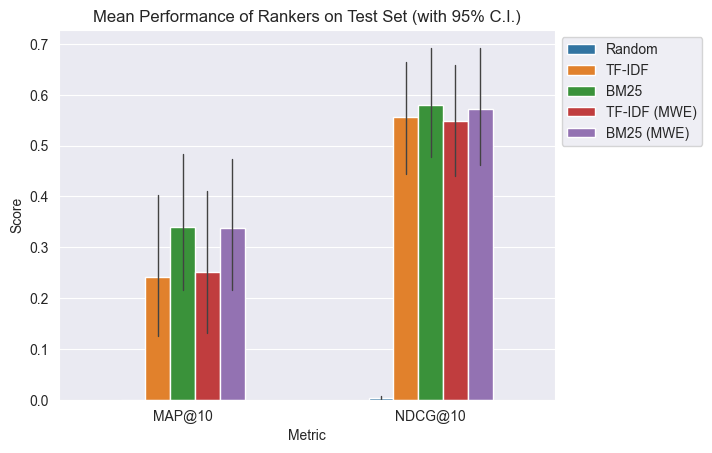

In [32]:
sns.barplot(data=metrics_df_long, x="metric", y="scores", hue="ranker", 
            estimator='mean', errorbar=('ci', 95), width=0.5, errwidth=1)

plt.title("Mean Performance of Rankers on Test Set (with 95% C.I.)")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()